In [1]:
import pandas as pd
import torch as t
import numpy as np
import os 
import matplotlib.pyplot as plt
from scipy import ndimage
import random
from tqdm import tqdm
from PIL import Image

In [2]:
device = t.device('cuda')

In [3]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [4]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device, dtype=t.float).unsqueeze(0)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1) + MOORE_OFFSETS).flatten(end_dim=1)
    idx_pad = cell_pixel_coords[:, 0].repeat_interleave(9).flatten().unsqueeze(-1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    idc, counts = t.unique(idx_pad, return_counts=True)
    return t.split(t.concatenate((idx_pad, nbh_coords), dim=-1), split_size_or_sections=counts.tolist())

In [5]:
STEP_SIZES = t.tensor([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)], device=device)
def MCS(batch, p_update):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = t.vstack(list(map(random.choice, frontiers))).type(t.long)
    
    step_size_idx = t.tensor(np.random.choice(
            STEP_SIZES.shape[0],
            size=src_coords.shape[0],
            replace=True,
    )).type(t.long)
    step_sizes = STEP_SIZES[step_size_idx]
    tgt_coords = t.hstack((src_coords[:, 0].unsqueeze(0).T, src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = src_coords[:, 0]
    src_j = src_coords[:, 1]
    src_k = src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    logit = t.log(t.hstack((p_update, (1-p_update))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch

In [6]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, p_update:t.Tensor, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, p_update)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    # one pixel is half of a micron, meaning that the number of pixels traveled needs to be divided by 2
    mean_distance = t.mean(distances)
    print(f"p_update: {p_update}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, p_update)[0]
    print(f"gradient: {grad}")
    return p_update - (eta * grad), grad, mean_distance, loss

In [7]:
temperature = t.tensor(1., device=device)
target_vol = 1.
batch = t.zeros(1,256,256, device=device)
batch[:,128,128] += 1

states = []
for i in tqdm(range(10_000)):
    batch = MCS(batch, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=20)

100%|██████████| 10000/10000 [00:52<00:00, 190.00it/s]


10000


In [9]:
temp = t.tensor(0.07, device=device)
temp.requires_grad_()
ref = t.zeros(1,128,128, device=device)
ref[:,64,64] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 4.

grads = []
mean_distances = []
losses = []
temps = [temp.detach().cpu().numpy()]
for i in range(700):
    temp.requires_grad_()
    batch = t.zeros(4000,128,128, device=device)
    batch[:,64,64] += 1
    temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, eta=1e-5, num_steps=800, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    temps.append(temp.detach().cpu().numpy())

 40%|███▉      | 316/800 [00:18<00:27, 17.36it/s]


KeyboardInterrupt: 

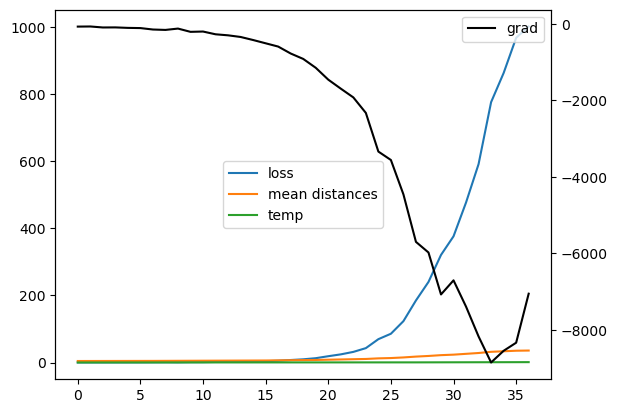

In [10]:
np.arange(len(temps[1:100]))
plt.plot(losses, label="loss")
plt.plot(mean_distances, label="mean distances")
plt.plot(temps[1:], label="temp")
plt.legend(loc="center")
axs2 = plt.twinx()
axs2.plot(grads, label="grad", color="black")
plt.legend()

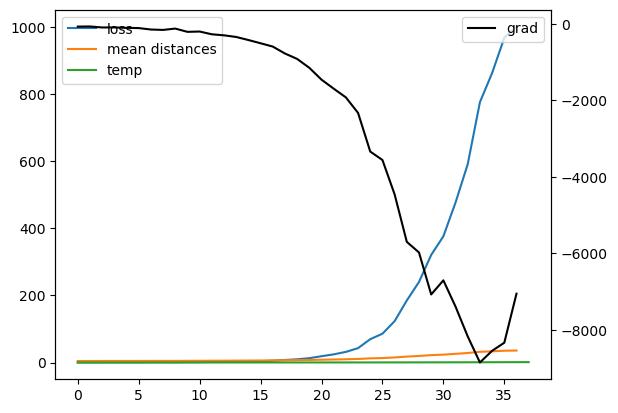

In [11]:
np.arange(len(temps[1:]))
plt.plot(losses[:110], label="loss")
plt.plot(mean_distances[:110], label="mean distances")
plt.plot(temps[:110], label="temp")
plt.legend()
axs2 = plt.twinx()
axs2.plot(grads[:110], label="grad", color="black")
plt.legend()

In [12]:
np.save("./data_ex2/losses4_exp.npy", np.array(losses))
np.save("./data_ex2/distances4_exp.npy", np.array(mean_distances))
np.save("./data_ex2/temperatures4_exp.npy", np.array(temps))
np.save("./data_ex2/grads4_exp.npy", np.array(grads))

In [13]:
len(temps)

147